# Graph construction via SPACE-GM

1. Construct cellular graphs with expression, vorinoi inputs
2. Construct `CellularGraphDataset` and attach node-level / graph-level tasks
3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
4. Train the GNN by randomly sampling subgraphs
5. Evaluate the GNN on node-level / graph-level tasks

In [1]:
import os, sys
# print(sys.version)
import warnings
warnings.filterwarnings("ignore")

from glob import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from graph_construction import *
import importlib
import pickle
import gzip
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, roc_curve


------------
## Step 1: Construct Cellular Graphs

We first construct cellular graphs as `networkx.Graph` using raw inputs including cell coordinates, cell types, biomarker expression, etc.

We provided some example files under `CellNeighs`:

In [2]:
dataset_root = '/Users/ccha0227/Documents/COMBINE_workshop/'

In [3]:
raw_data_root = os.path.join(dataset_root, 'TMAs/')
preprocess_root = os.path.join(dataset_root, 'preprocess/')
nx_graph_root = os.path.join(dataset_root, 'GNN_data/')
fig_save_root = os.path.join(dataset_root, 'figures/')
model_save_root = os.path.join(dataset_root, 'model/')
list_path = [raw_data_root, preprocess_root, nx_graph_root, fig_save_root, model_save_root]
for path in list_path:
    os.makedirs(path, exist_ok=True)
    print(path)

/Users/ccha0227/Documents/COMBINE_workshop/TMAs/
/Users/ccha0227/Documents/COMBINE_workshop/preprocess/
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/
/Users/ccha0227/Documents/COMBINE_workshop/figures/
/Users/ccha0227/Documents/COMBINE_workshop/model/


In [4]:
#### paths of input files
graph_label_file = os.path.join(preprocess_root, "CellNeigh_prognosis_file_140TMAs.csv")
feature_file = os.path.join(preprocess_root + 'features_mean_clr_all.pkl')
voronoi_polygons_file = os.path.join(preprocess_root + 'voronoi_polygons_all.pkl')
points_file = os.path.join(preprocess_root + 'points_all.npz')

In [5]:
#### region id, 70, _A, _B
region_ids = []
for r in range(70):
    region_id_A = f'reg{r+1:03d}_A'  # Formats the number with zero-padding to 3 digits
    region_ids.append(region_id_A)    # Append the region ID with '_A'
    
    region_id_B = f'reg{r+1:03d}_B'   # Formats the number with zero-padding to 3 digits
    region_ids.append(region_id_B)    # Append the region ID with '_B'

In [6]:
### import input files
with open(voronoi_polygons_file, 'rb') as f:
    voronoi_polygons_all = pickle.load(f)

with open(feature_file, 'rb') as f:
    features_mean_all = pickle.load(f)

### load and access numpy.array
points_all = np.load(points_file)
points_all = [points_all[f'arr_{i}'] for i in range(len(points_all.files))]

In [12]:
### checking
print(f'are the numbers of samples the same in the input files: {len(voronoi_polygons_all[1]) == len(features_mean_all[1]) == len(points_all[1])}')
print(len(points_all[0]))
print(len(features_mean_all[69]))
# points_all[0].any() == 'Nan'


are the numbers of samples the same in the input files: True
1164
2266


### A networkx.graph can be constructed using the inputs above

Processing reg001_A
markers of features Index(['CELL_ID', 'region_id', 'X', 'Y', 'SIZE', 'CELL_TYPE',
       'neighborhood name', 'BM-CD44', 'BM-FOXP3', 'BM-CD8', 'BM-p53',
       'BM-GATA3', 'BM-CD45', 'BM-T-bet', 'BM-beta-catenin', 'BM-HLA-DR',
       'BM-PD-L1', 'BM-Ki67', 'BM-CD45RA', 'BM-CD4', 'BM-CD21', 'BM-MUC-1',
       'BM-CD30', 'BM-CD2', 'BM-Vimentin', 'BM-CD20', 'BM-LAG-3',
       'BM-Na-K-ATPase', 'BM-CD5', 'BM-IDO-1', 'BM-Cytokeratin', 'BM-CD11b',
       'BM-CD56', 'BM-aSMA', 'BM-BCL-2', 'BM-CD25', 'BM-CD11c', 'BM-PD-1',
       'BM-Granzyme B', 'BM-EGFR', 'BM-VISTA', 'BM-CD15', 'BM-ICOS',
       'BM-Synaptophysin', 'BM-GFAP', 'BM-CD7', 'BM-CD3', 'BM-Chromogranin A',
       'BM-CD163', 'BM-CD45RO', 'BM-CD68', 'BM-CD31', 'BM-Podoplanin',
       'BM-CD34', 'BM-CD38', 'BM-CD138', 'BM-CDX2', 'BM-Collagen IV',
       'BM-CD194', 'BM-MMP9', 'BM-CD71', 'BM-CD57', 'BM-MMP12'],
      dtype='object')
Processing reg001_B
markers of features Index(['CELL_ID', 'region_id', 'X', 'Y', 'S

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

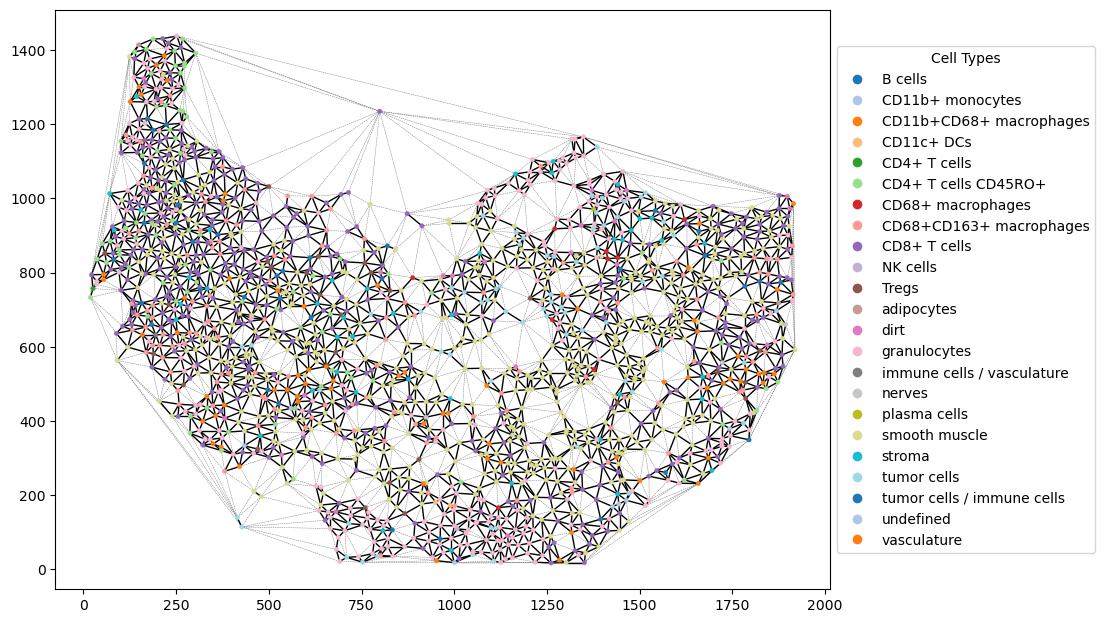

In [7]:
construct_cellular_graph(fig_save_root,nx_graph_root,region_ids[:10], voronoi_polygons_all, features_mean_all)

In [30]:
### load graph files
graph_outputs = [
    os.path.join(nx_graph_root, f'G_{region_id}.gpkl')
    for region_id in region_ids
]

G_all = []
for graph_output in graph_outputs[:10]:
    print (graph_output)
    with open(graph_output, 'rb') as f:
        G = pickle.load(f)
    G_all.append(G)


/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg001_A.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg001_B.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg002_A.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg002_B.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg003_A.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg003_B.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg004_A.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg004_B.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg005_A.gpkl
/Users/ccha0227/Documents/COMBINE_workshop/GNN_data/G_reg005_B.gpkl


The function `construct_cellular_graph` also generates some visualisations for each region, stored under `figures` folder.

Here is an example:

<Figure size 640x480 with 0 Axes>

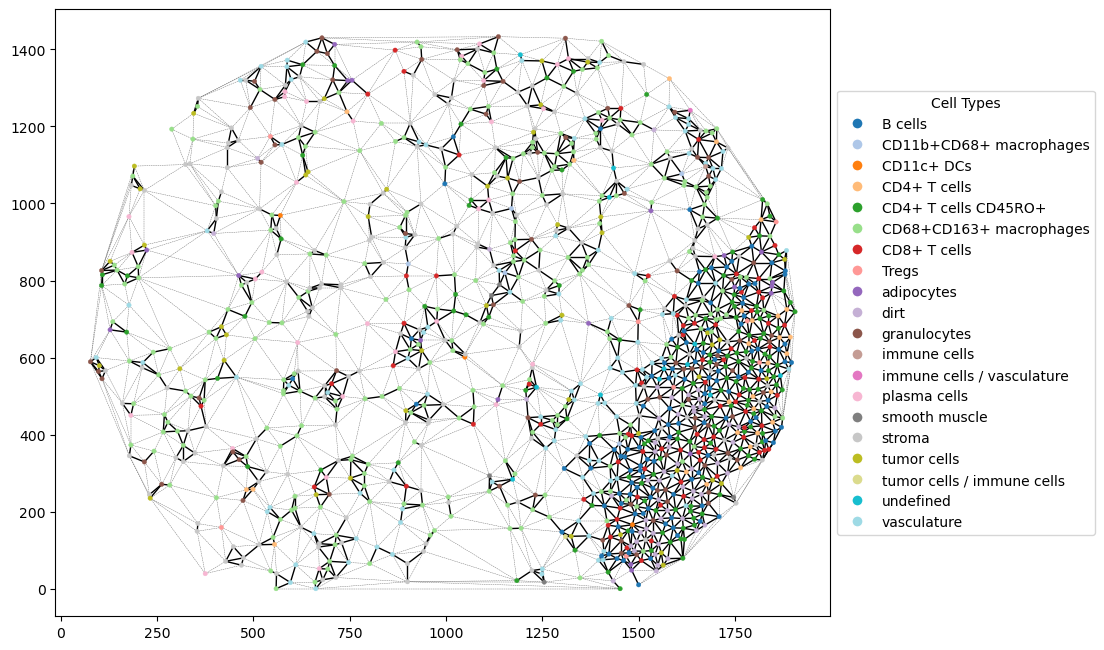

In [31]:
# Visualisation of cellular graph
from IPython.display import Image
graph_img = '/Users/ccha0227/Documents/COMBINE_workshop/figures/reg001_A_graph.png'
pil_img = Image(filename=graph_img)
display(pil_img)

------------
## Step 2: Construct `CellularGraphDataset`

`CellularGraphDataset` will be the major data container used in model training and evaluation. This object also handles all the featurization, subgraph sampling, and other necessary functionalities for SPACE-GM.

We previously saved all regions as networkx graphs, now we initialize the dataset object using these graph files

In [32]:
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'GNN_data',  # is the folder where we saved nx graphs
    'processed_folder_name': 'tg_intst_clr',  # processed dataset files will be stored here
    
    'node_features': ["cell_type", "SIZE", "biomarker_expression", "neighborhood_composition", "center_coord"], 
    'edge_features': ["edge_type", "distance"],

    'subgraph_size': 3,  # indicating we want to sample 3-hop subgraphs from these regions (for training/inference), this is a core parameter for SPACE-GM.
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,

}
feature_kwargs = {
    "biomarker_expression_process_method": "raw",
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

In [4]:
dataset = spacegm.data.CellularGraphDataset(dataset_root, **dataset_kwargs)

In [44]:
### to do: edit the plot function
unique_cell_types = sorted(set([G.nodes[n]['cell_type'] for n in G.nodes 
                                if G.nodes[n].get('cell_type') is not None 
                                and not pd.isna(G.nodes[n]['cell_type'])]
                              ))
# Adding 'nan' explicitly to handle NaN values
if any(pd.isna(G.nodes[n].get('cell_type')) for n in G.nodes):
    unique_cell_types.append('nan')

# Replace NaN values in 'CELL_TYPE' with the string 'nan'
G.nodes[n].get('cell_type') = G.nodes[n].get('cell_type').apply(lambda x: 'nan' if pd.isna(x) else x)

cell_type_to_color = {ct: matplotlib.cm.get_cmap("tab20")(i % 20) for i, ct in enumerate(unique_cell_types)}

node_colors = [cell_type_to_color[G.nodes[n]['cell_type']] for n in G.nodes]

print(len(node_colors))
len(G.nodes)

{'Bulk tumor': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'Follicle': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), 'Immune-infiltrated stroma': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'Macrophage enriched': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0), 'Smooth muscle': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'T cell enriched': (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), 'Tumor boundary': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'Vascularized smooth muscle': (1.0, 0.596078431372549, 0.5882352941176471, 1.0), 'nan': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)}
2260


2260

The full cellular graph for each region in the dataset can be accessed using the class method `get_full`:

In [74]:
i = 0
dataset.get_full(i)

Data(x=[1160, 89], edge_index=[2, 6884], edge_attr=[6884, 2], num_nodes=1160, region_id='reg001_A', component_id=0)

And the n-hop (n=3 in this example) subgraph of region `i` around its center node `j` can be accessed using the class method `get_subgraph`: 

In [50]:
i = 0
j = 1034
dataset.get_subgraph(i, j)

Data(x=[42, 89], edge_index=[2, 204], edge_attr=[204, 2], center_node_index=35, original_center_node=1034, num_nodes=42, region_id='reg001_A', component_id=0)

By default, indexing the dataset object will yield an n-hop subgraph around a randomly picked center node (see class method `pick_center`) in the specified region:

In [75]:
len(dataset)
dataset[0]

Data(x=[36, 89], edge_index=[2, 176], edge_attr=[176, 2], center_node_index=3, original_center_node=202, num_nodes=36, region_id='reg001_A', component_id=0)

There is also a quick plotting functions for subgraphs: `plot_subgraph`

(1551.6, 1736.4, 276.6, 461.4)

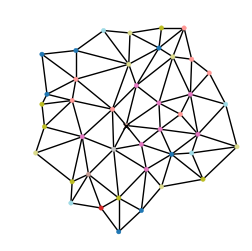

In [51]:
i = 0
j = 1034

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

<br/>

During training, due to the high throughput of data streaming, on-the-fly calculation of subgraph might be slow. To speed up data loading, we will save all subgraphs to chunk files first and load them during training/inference.

In [5]:
dataset.save_all_subgraphs_to_chunk()

In [62]:
import time

dataset.clear_cache()
dataset.set_subgraph_source('on-the-fly') # Can also be set through the `subgraph_source` argument
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Sampling 5000 subgraphs on-the-fly took %.2f seconds" % (t1 - t0))

dataset.clear_cache()
dataset.set_subgraph_source('chunk_save')  
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Loading 5000 subgraphs from chunk save took %.2f seconds" % (t1 - t0))


Sampling 5000 subgraphs on-the-fly took 6.79 seconds
Loading 5000 subgraphs from chunk save took 4.73 seconds


<br/>

Transformers will be used to mask features, add node-level and graph-level tasks, etc.

In [ ]:
### editting label file
graph_label = pd.read_csv(graph_label_file)

# Duplicate each row
graph_label = graph_label.loc[graph_label.index.repeat(2)].reset_index(drop=True)

# Add '_A' and '_B' to the duplicated rows in 'REGION_ID' column
graph_label['REGION_ID'] = graph_label['REGION_ID'] + ['_A' if i % 2 == 0 else '_B' for i in range(len(graph_label))]

graph_label = pd.read_csv(graph_label_file)
graph_label['OS_status'] = 1-graph_label['OS_Censor']
graph_label.to_csv(os.path.join(dataset_root,'CellNeigh_prognosis_file_140TMAs.csv'), index=False)

In [6]:
transformers = [
    # `AddCenterCellType` will add `node_y` attribute to the subgraph for node-level prediction task
    # In this task we will mask the cell type of the center cell (replace it by a placeholder cell type)
    # and use its neighborhood to predict the true cell type
    spacegm.AddCenterCellType(dataset),
    # `AddGraphLabel` will add `graph_y` and `graph_w` attributes to the subgraph for graph-level prediction task
    spacegm.AddGraphLabel(graph_label_file, tasks=['OS_status']),
    # Transformer `FeatureMask` will zero mask all feature items not included in its argument
    # In this tutorial we perform training/inference using cell types and center cell's size feature
    # Note that `center_coord` should NOT be used as node features
    spacegm.FeatureMask(dataset, use_center_node_features=['cell_type', 'SIZE'], use_neighbor_node_features=['cell_type']),
]

dataset.set_transforms(transformers)

------

### Step 3 Initialize a Graph Neural Network (GNN)

Now we construct a graph neural network for predicting `survival_status`.

The graph neural network will be composed of 3 parts:
1. The backbone GNN with specified number of graph convolutional layers
2. A node task prediction module if there are node-level tasks defined, this module will be constructed based on the node embedding of the center node
3. A graph task prediction module if there are graph-level tasks defined, this module will be constructed based on the graph-pooled embedding of all the nodes

In [7]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,  # same number of layers as number of hops in the subgraphs
    'num_node_type': len(dataset.cell_type_mapping) + 1,  # number of embeddings for different cell types (plus one placeholder cell type)
    'num_feat': dataset[0].x.shape[1] - 1,  # exclude the cell type column
    'emb_dim': 512, 
    'num_node_tasks': len(dataset.cell_type_mapping),  # A multi-class classification task: predicting center cell type
    'num_graph_tasks': 1,  # a binary classification task
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cuda'

model_folder = 'GIN_public_intst_clr'
model_path = os.path.join(model_save_root, model_folder, 'model_save_553.pt')
model.load_state_dict(torch.load(model_path))

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(30, 512)
    (feat_embedding): Linear(in_features=88, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=29, bias=True)
  )
)

------

### Step 4 Train the GNN

GNNs in SPACE-GM are trained using n-hop subgraphs, see `data.SubgraphSampler` for details.

In this tutorial we specified one node-level task (predicting center cell type) and one graph-level task (predicting binary survival status), each task will have a specific loss function.


In [78]:
train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  # Weight of graph task loss relative to node task loss
    'num_iterations': 1e5,  # In this demo we only train for 50 iterations/batches

    # Loss functions
    'node_task_loss_fn': nn.CrossEntropyLoss(),
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),    

    # Evaluation during training
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,  # Evaluate the model every 10 iterations
}

On-the-fly evaluation of model performances is included in the training pipeline:

In [79]:
evaluate_kwargs = {
    'node_task_evaluate_fn': spacegm.inference.cell_type_prediction_evaluate_fn,
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_node_task_evaluate_fn': spacegm.inference.full_graph_cell_type_prediction_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 300,
    'score_file': os.path.join(model_save_root, model_folder, 'space-gm_ROCAUC_score.txt'),
    'model_folder': os.path.join(model_save_root, model_folder),
}
train_kwargs.update(evaluate_kwargs)

Run training:

In [ ]:
model = spacegm.train.train_subgraph(
    model, 
    dataset,
    device,
    **train_kwargs)

Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40
Finished iterations 50
Finished iterations 60
Finished iterations 70
Finished iterations 80
Finished iterations 90
Finished iterations 100, node loss 3.31, graph loss 0.72
Finished iterations 110, node loss 3.30, graph loss 0.72
Finished iterations 120, node loss 3.30, graph loss 0.71
Finished iterations 130, node loss 3.30, graph loss 0.71
Finished iterations 140, node loss 3.30, graph loss 0.71
Finished iterations 150, node loss 3.30, graph loss 0.71
Finished iterations 160, node loss 3.30, graph loss 0.71
Finished iterations 170, node loss 3.30, graph loss 0.71
Finished iterations 180, node loss 3.30, graph loss 0.71
Finished iterations 190, node loss 3.29, graph loss 0.71
Finished iterations 200, node loss 3.29, graph loss 0.71
Finished iterations 210, node loss 3.29, graph loss 0.71
Finished iterations 220, node loss 3.29, graph loss 0.71
Finished iterations 230, node loss 3.29, graph loss 

Evaluation metrics during training are saved in the specified score file:

In [ ]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Intermediate model weights are saved in the specified model folder:

In [23]:
print(os.listdir(evaluate_kwargs['model_folder']))

['model_save_0.pt', 'model_save_2.pt', 'model_save_4.pt', 'model_save_3.pt', 'model_save_1.pt']


------

### Step 5 Evaluate the GNN

As GNNs are trained using subgraphs, there are two ways for evaluation (especially for graph-level tasks):

- Sample subgraphs and calculate metrics by treating each subgraph as an independent data point;
- Iterate over all the subgraphs (cells) of each region and calculate metrics, for graph-level tasks treat the aggregated (average) prediction from a region as an independent data point;

This is also reflected in the on-the-fly evaluation above: `spacegm.train.evaluate_by_sampling_subgraphs` and `spacegm.train.evaluate_by_full_graph`.

Here we demonstrate the two types of evaluation:

In [12]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device,  print_progress=True)  #inds=np.arange(4),

# Aggregated (average) predictions of each region
avg_preds = []
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))
    avg_preds.append(avg_pred)
score = spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

predict on 0
predict on 1
predict on 2
predict on 3
predict on 4
predict on 5
predict on 6
predict on 7
predict on 8
predict on 9
predict on 10
predict on 11
predict on 12
predict on 13
predict on 14
predict on 15
predict on 16
predict on 17
predict on 18
predict on 19
predict on 20
predict on 21
predict on 22
predict on 23
predict on 24
predict on 25
predict on 26
predict on 27
predict on 28
predict on 29
predict on 30
predict on 31
predict on 32
predict on 33
predict on 34
predict on 35
predict on 36
predict on 37
predict on 38
predict on 39
predict on 40
predict on 41
predict on 42
predict on 43
predict on 44
predict on 45
predict on 46
predict on 47
predict on 48
predict on 49
predict on 50
predict on 51
predict on 52
predict on 53
predict on 54
predict on 55
predict on 56
predict on 57
predict on 58
predict on 59
predict on 60
predict on 61
predict on 62
predict on 63
predict on 64
predict on 65
predict on 66
predict on 67
predict on 68
predict on 69
predict on 70
predict on 71
pr

In [40]:
# Aggregated (max) predictions of each region
max_preds = []
predicted_probs = []
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    max_pred = np.max(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, max_pred))
    max_preds.append(max_pred)
    predicted_probs.append(predicted_prob)
len(predicted_probs[0])

On region reg001, average prediction: 1.000
On region reg002, average prediction: 1.000
On region reg003, average prediction: 0.998
On region reg004, average prediction: 1.000
On region reg005, average prediction: 1.000
On region reg006, average prediction: 1.000
On region reg007, average prediction: 1.000
On region reg008, average prediction: 1.000
On region reg009, average prediction: 1.000
On region reg010, average prediction: 1.000
On region reg011, average prediction: 0.993
On region reg012, average prediction: 1.000
On region reg013, average prediction: 1.000
On region reg014, average prediction: 1.000
On region reg015, average prediction: 1.000
On region reg016, average prediction: 1.000
On region reg017, average prediction: 1.000
On region reg018, average prediction: 1.000
On region reg019, average prediction: 1.000
On region reg020, average prediction: 1.000
On region reg021, average prediction: 1.000
On region reg022, average prediction: 1.000
On region reg023, average predic

1160

In [16]:
graph_label = pd.read_csv(graph_label_file)
graph_label['OS']

0      71.335
1      71.335
2     137.640
3     137.640
4       0.394
       ...   
65     16.200
66     18.540
67     18.540
68     40.500
69     40.500
Name: OS, Length: 70, dtype: float64

In [28]:
print(a)

0.3067226890756303


In [41]:
from lifelines.utils import concordance_index
a = concordance_index(event_times = graph_label['OS'], predicted_scores = , event_observed=None)
a

0.3773109243697479

In [ ]:
sksurv.metrics.concordance_index_censored(event_indicator, event_time, estimate, tied_tol=1e-08)

In [ ]:
def concordance_index(
    y_true: Union[Tensor, ndarray], 
    y_pred: Union[Tensor, ndarray]
) -> float:
    """Concordance-index Evaluation.

    For coxph model
    Args:
        y_true (Union[Tensor, ndarray]): Observed time (at the first column) and event indicator (at the second column). 
        y_pred (Union[Tensor, ndarray]): Predicted value (proportional hazard).

    For discrete model
    Args:
        y_true (Union[Tensor, ndarray]): Observed time (at the first column) and event indicator (at the second column). 
        y_pred (Union[Tensor, ndarray]): Predicted value (time-dependent hazard function).
    """
    if isinstance(y_pred, Tensor):
        y_pred = y_pred.numpy()
    if isinstance(y_true, Tensor):
        y_true = y_true.numpy()

    if y_pred.shape[1] == 1: # coxph model if its prediction is a scalar value indicating proportional hazard
        y_true = np.squeeze(y_true)
        y_pred = np.squeeze(y_pred)
        t, e = y_true[:, 0], y_true[:, 1].astype(np.bool_)
        return concordance_index_censored(e, t, -y_pred, tied_tol=1e-08)[0]
    else: # discrete model
        y_t, y_e = y_true[:, 0], y_true[:, 1].astype(np.bool_)
        survival = np.cumprod(1.0 - y_pred, axis=1)
        risk = np.sum(survival, axis=1)
        return concordance_index_censored(y_e, y_t, -risk, tied_tol=1e-08)[0]


In [31]:
# [avg_pred, top1_acc, top3_acc, top5_acc]
score_cell_avg, score_cell_1, score_cell_3, score_cell_5 = spacegm.inference.full_graph_cell_type_prediction_evaluate_fn(dataset, node_preds, print_res=True)

NODE Avg-pred: 0.28, Acc top-1 0.38; top-3 0.67; top-5 0.81


[0.27639958, 0.3805939114560205, 0.6691618560261643, 0.8141577326200193]

In [35]:
def full_graph_TMA_classification_evaluate_fn( ## editted version of 'full_graph_graph_classification_evaluate_fn'
        dataset,
        graph_results,
        aggr='mean',
        print_res=True):

    n_tasks = dataset[0].graph_y.data.numpy().size
    graph_TMA_preds = []
    graph_TMA_ys = []
    graph_TMA_ws = []
    for i in graph_results:
        graph_pred = [p for p in graph_results[i] if ((p is not None) and np.all(p == p))]
        graph_pred = np.stack(graph_pred, 0)

        if aggr == 'mean':
            graph_pred = np.nanmean(graph_pred, 0)
        else:
            raise NotImplementedError("Only mean-aggregation is supported now")

        graph_y = dataset[i].graph_y.data.numpy().flatten()
        graph_w = dataset[i].graph_w.data.numpy().flatten()
        graph_TMA_preds.append(graph_pred)
        graph_TMA_ys.append(graph_y)
        graph_TMA_ws.append(graph_w)

    graph_TMA_preds = np.concatenate(graph_TMA_preds, 0).reshape((-1, n_tasks))
    graph_TMA_ys = np.concatenate(graph_TMA_ys, 0).reshape((-1, n_tasks))
    graph_TMA_ws = np.concatenate(graph_TMA_ws, 0).reshape((-1, n_tasks))
    
    return graph_TMA_preds, graph_TMA_ys, graph_TMA_ws
    # graph_classification_evaluate_fn(graph_preds, graph_ys, graph_ws, print_res=print_res)

In [36]:
graph_TMA_preds, graph_TMA_ys, graph_TMA_ws = full_graph_TMA_classification_evaluate_fn(dataset, graph_preds, print_res=True)

In [69]:
print(graph_TMA_ys)
graph_TMA_preds


[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]]


array([[ -6.714613 ],
       [ -6.7733326],
       [ -4.5557013],
       [ -2.9329593],
       [  4.04495  ],
       [  6.047808 ],
       [ 10.419873 ],
       [ 11.558368 ],
       [  4.6544933],
       [  6.634712 ],
       [ -5.048003 ],
       [ -6.4267516],
       [ -5.9436054],
       [ -6.229305 ],
       [  6.0605164],
       [  1.9035448],
       [  4.274081 ],
       [ 27.376505 ],
       [ -2.6736743],
       [ -3.4578454],
       [ -8.52797  ],
       [-10.735082 ],
       [-11.66307  ],
       [ -6.1286836],
       [ -7.0832295],
       [ -3.0703301],
       [ -4.958787 ],
       [ -4.5018954],
       [  2.3682537],
       [ 13.404602 ],
       [ -4.336084 ],
       [ -4.2345605],
       [ -6.153804 ],
       [ -4.1700797],
       [  3.8802083],
       [ 13.022223 ],
       [  8.363188 ],
       [ 18.884945 ],
       [ -3.5321743],
       [ -4.4812436],
       [ -8.292048 ],
       [ -7.8083396],
       [  7.3275595],
       [  5.270405 ],
       [-19.683722 ],
       [ -

In [37]:
b = concordance_index(event_times = graph_label['OS'], predicted_scores = graph_TMA_preds, event_observed=None)
b

0.30210084033613444

In [ ]:
roc_auc = roc_auc_score(y_score = graph_TMA_preds, y_true = graph_TMA_ys)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_score = graph_preds_r, y_true = graph_ys_r)


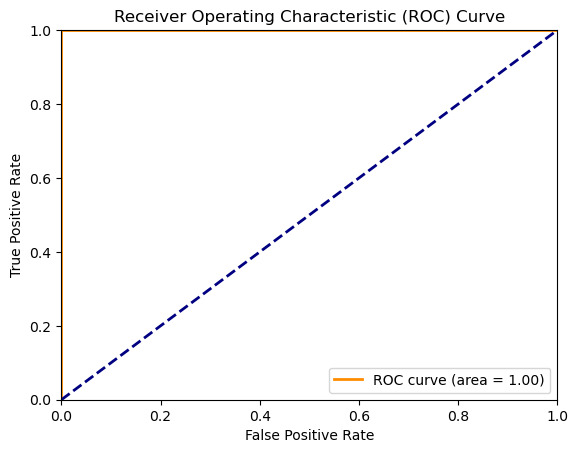

In [67]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Evaluation by sampling subgraphs
node_preds_r, node_labels_r, graph_preds_r, graph_ys_r, graph_ws_r = spacegm.inference.collect_predict_by_random_sample(
    model, dataset, device, num_eval_iterations=300)  ## inds=np.arange(4), 
score_r = spacegm.inference.graph_classification_evaluate_fn(graph_preds_r, graph_ys_r, graph_ws_r)

GRAPH [0.8578358523739837]


In [15]:
print(graph_preds)
print(graph_ys)
print(graph_ws)
score

[[-4.3423085 ]
 [-0.3971726 ]
 [ 1.2988949 ]
 ...
 [ 0.08969501]
 [-1.4646034 ]
 [ 2.6157827 ]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]
[[1.       ]
 [1.       ]
 [1.       ]
 ...
 [1.       ]
 [1.0588236]
 [1.0588236]]


[0.8578358523739837]

In [21]:
graph_preds[2]

array([1.2988949], dtype=float32)

In [ ]:
X, y = fetch_openml(data_id=1464, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)

# Microenvironment clustering/ subgraphs 